In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import yfinance as yf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pytz

In [2]:
xmr = yf.Ticker("XMR-USD XMR-BTC XMR-EUR XMR-CNY")
df = yf.download(tickers = "XMR-USD",
                     period = "max",
                     interval = "1d")
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df['Date'].max().date()

datetime.date(2023, 10, 16)

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000
...,...,...,...,...,...,...,...
2163,2023-10-12,153.852783,154.344238,151.021347,152.341812,152.341812,65445853
2164,2023-10-13,152.339523,154.368774,151.051971,153.590515,153.590515,51282283
2165,2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438
2166,2023-10-15,152.833466,153.465881,152.173126,152.448990,152.448990,31895675


In [5]:
### Get Gold, Silver and Copper closing prices in our dataframe's date range.

### Define date range
start_Date = df['Date'].min().date()
end_Date = df['Date'].max().date()

gold = yf.Ticker("GC=F")
gold_hist = gold.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
gold_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
gold_hist.reset_index(inplace=True)
gold_hist['Date'] = gold_hist['Date'].dt.tz_convert(pytz.UTC)
gold_close=gold_hist[['Close']]

silver = yf.Ticker("SI=F")
silver_hist = silver.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
silver_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
silver_hist.reset_index(inplace=True)
silver_hist['Date'] = silver_hist['Date'].dt.tz_convert(pytz.UTC)
silver_close=silver_hist[['Close']]

copper = yf.Ticker("HG=F")
copper_hist = copper.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
copper_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
copper_hist.reset_index(inplace=True)
copper_hist['Date'] = copper_hist['Date'].dt.tz_convert(pytz.UTC)
copper_close=copper_hist[['Close']]
copper_date=copper_hist[['Date']]

In [6]:
metal_df  = pd.concat([gold_close, silver_close,copper_close], axis=1)
metal_df .columns = ['gold_close', 'silver_close', 'copper_close']
metal_df 


,gold_close,silver_close,copper_close
0,1285.599976,16.943001,3.0800
1,1272.400024,16.844000,3.0695
2,1277.300049,17.023001,3.1115
3,1281.500000,17.052000,3.0600
4,1276.500000,16.950001,3.0490
...,...,...,...
1485,1849.500000,21.740999,3.6425
1486,1861.000000,21.775999,3.6320
1487,1872.800049,21.957001,3.6140
1488,1869.300049,21.792000,3.5940


In [7]:
bitcoin = yf.Ticker("BTC-USD")
bitcoin_hist = bitcoin.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
bitcoin_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
bitcoin_hist.reset_index(inplace=True)
bitcoin_hist['Date'] = bitcoin_hist['Date'].dt.tz_convert(pytz.UTC)
bitcoin_close=bitcoin_hist[['Close']]

ethereum = yf.Ticker("ETH-USD")
ethereum_hist = ethereum.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
ethereum_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
ethereum_hist.reset_index(inplace=True)
ethereum_hist['Date'] = ethereum_hist['Date'].dt.tz_convert(pytz.UTC)
ethereum_close=ethereum_hist[['Close']]

tether = yf.Ticker("USDT-USD")
tether_hist = tether.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
tether_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
tether_hist.reset_index(inplace=True)
tether_hist['Date'] = tether_hist['Date'].dt.tz_convert(pytz.UTC)
tether_close=tether_hist[['Close']]

bnb = yf.Ticker("BNB-USD")
bnb_hist = bnb.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
bnb_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
bnb_hist.reset_index(inplace=True)
bnb_hist['Date'] = bnb_hist['Date'].dt.tz_convert(pytz.UTC)
bnb_close=bnb_hist[['Close']]

xrp = yf.Ticker("XRP-USD")
xrp_hist = xrp.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
xrp_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
xrp_hist.reset_index(inplace=True)
xrp_hist['Date'] = xrp_hist['Date'].dt.tz_convert(pytz.UTC)
xrp_close=xrp_hist[['Close']]
# xrp_date=xrp_hist[['Date']]..strftime("%Y-%m-%d")


In [8]:
crypto_df  = pd.concat([bitcoin_close, ethereum_close,tether_close,bnb_close, xrp_close], axis=1)
crypto_df .columns = ['bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close']
crypto_df

,bitcoin_close,ethereum_close,tether_close,bnb_close,xrp_close
0,7143.580078,320.884003,1.008180,1.990770,0.217488
1,6618.140137,299.252991,1.006010,1.796840,0.206483
2,6357.600098,314.681000,1.008990,1.670470,0.210430
3,5950.069824,307.907990,1.012470,1.519690,0.197339
4,6559.490234,316.716003,1.009350,1.686620,0.203442
...,...,...,...,...,...
2162,26873.320312,1566.254761,0.999752,206.533417,0.488838
2163,26756.798828,1539.612427,0.999708,205.229416,0.483050
2164,26862.375000,1552.089478,0.999960,206.036118,0.485699
2165,26861.707031,1555.256836,1.000106,206.601898,0.486775


In [9]:
sp = yf.Ticker("^GSPC")
sp_hist = sp.history(start=df['Date'].min(), end=df['Date'].max(), actions=False)
sp_hist.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
sp_hist.reset_index(inplace=True)
sp_hist['Date'] = sp_hist['Date'].dt.tz_convert(pytz.UTC)
sp_close=sp_hist[['Close']]

In [10]:
crypto_metal_df = pd.concat([crypto_df, metal_df, sp_close ], axis=1)
crypto_metal_df.columns = ['bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close',
                     'gold_close', 'silver_close', 'copper_close','sp_close']
crypto_metal_df.interpolate(inplace=True)
crypto_metal_df1=pd.concat([df, crypto_metal_df], axis=1)

df = crypto_metal_df1.copy()
df.interpolate(inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2168 non-null   datetime64[ns]
 1   Open            2168 non-null   float64       
 2   High            2168 non-null   float64       
 3   Low             2168 non-null   float64       
 4   Close           2168 non-null   float64       
 5   Adj Close       2168 non-null   float64       
 6   Volume          2168 non-null   int64         
 7   bitcoin_close   2168 non-null   float64       
 8   ethereum_close  2168 non-null   float64       
 9   tether_close    2168 non-null   float64       
 10  bnb_close       2168 non-null   float64       
 11  xrp_close       2168 non-null   float64       
 12  gold_close      2168 non-null   float64       
 13  silver_close    2168 non-null   float64       
 14  copper_close    2168 non-null   float64       
 15  sp_c

In [12]:
def clean_hash_difficulty_files(files: list):
    final_files = []
    for file in files:
        ### Read xmr_difficulty file and make necessary changes
        # file = pd.read_csv(f'./data_phase2/{file}', index_col=None)
        # D:\quera\tamrin\faz2\XMR_difficulty.csv
        file = pd.read_csv(f'{file}', index_col=None)
        file.drop(columns=['Unnamed: 0'], inplace=True)

        ### Convert hourly difficulty rates to daily
        # First, ensure that the 'time' column is of datetime type
        file['time'] = pd.to_datetime(file['time'])

        # Set 'time' as the index for the DataFrame
        file.set_index('time', inplace=True)

        # Use the resample method to aggregate hourly data to daily data
        rate = ''
        if 'difficulty' in file.columns:
            rate_col = 'difficulty'
        elif 'hash' in file.columns:
            rate_col = 'hash'
        converted_rate = file[rate_col].resample('D').mean()
        converted_rate = pd.DataFrame(converted_rate)
        converted_rate.reset_index(inplace=True)
        
        ### Remove UTC time format from its time column
        converted_rate['time'] = converted_rate['time'].dt.tz_localize(None)

        ### Filter converted_rate date range to correspond to date range in df( aka XMR-Monero)
        start_date = df['Date'].min()
        ### converted_rate ends in 2023-10-08 so forcibly we have to cut df short to 2023-10-08 
        end_date = df['Date'].max()

        ### Final file named With daily rates instead of hourly 
        ### And Correct date range
        ### Note : There are still 6 rows missing in converted_rate_with_range which has to be dropped from df  
        converted_rate_with_range = converted_rate[
            (converted_rate['time'] >= start_date) & (converted_rate['time'] <= end_date)
        ]
        converted_rate_with_range.reset_index(drop=True, inplace=True)
        converted_rate_with_range = converted_rate_with_range.rename(columns={'time': 'Date'})
        final_files.append(converted_rate_with_range)
    return final_files

In [13]:
### difficulty_hash_final_files contains a list with 2 elements 
### At index 0 it has final xmr_difficulty file
### At index 1 it has final xmr_hash file 
difficulty_hash_final_files = clean_hash_difficulty_files(files=['data_phase2/XMR_difficulty.csv', 'data_phase2/XMR_hash.csv'])

In [14]:
### Merge difficulty and hash into XMR-Monro (our main df)
for file in difficulty_hash_final_files:
    df = pd.merge(df, file, on='Date')
df
# df.columns

,Date,Open,High,Low,Close,Adj Close,Volume,bitcoin_close,ethereum_close,tether_close,bnb_close,xrp_close,gold_close,silver_close,copper_close,sp_close,difficulty,hash
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,7143.580078,320.884003,1.008180,1.990770,0.217488,1285.599976,16.943001,3.0800,2584.620117,2.806786e+10,2.338989e+08
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,6618.140137,299.252991,1.006010,1.796840,0.206483,1272.400024,16.844000,3.0695,2582.300049,2.805339e+10,2.337782e+08
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,6357.600098,314.681000,1.008990,1.670470,0.210430,1277.300049,17.023001,3.1115,2584.840088,2.805339e+10,2.337782e+08
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,5950.069824,307.907990,1.012470,1.519690,0.197339,1281.500000,17.052000,3.0600,2578.870117,2.805339e+10,2.337782e+08
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,6559.490234,316.716003,1.009350,1.686620,0.203442,1276.500000,16.950001,3.0490,2564.620117,2.805339e+10,2.337782e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2023-10-04,147.168442,150.702347,145.940781,150.469055,150.469055,59400400,27799.394531,1647.838135,1.000437,213.413086,0.532931,1927.400024,22.726999,3.5800,4327.779785,3.423015e+11,2.852512e+09
2156,2023-10-05,150.474197,151.328369,148.565491,149.623718,149.623718,55704972,27415.912109,1611.476440,1.000089,210.679672,0.523366,1927.400024,22.726999,3.5800,4327.779785,3.338542e+11,2.782118e+09
2157,2023-10-06,149.623337,152.669296,148.641647,151.992264,151.992264,49535004,27946.597656,1645.831543,1.000436,213.555527,0.526193,1927.400024,22.726999,3.5800,4327.779785,3.580862e+11,2.984052e+09
2158,2023-10-07,151.988235,155.247528,151.100983,155.212143,155.212143,61159796,27968.839844,1634.511230,1.000550,212.364471,0.521906,1927.400024,22.726999,3.5800,4327.779785,3.445453e+11,2.871211e+09


In [15]:
### Add Target vector as a separate column to dataframe for later reference
### This is Target Vector
df['Price_Direction'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [16]:
df['HighLow'] = df['High'] - df['Low']
df['OpenClose'] = df['Open'] - df['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume,bitcoin_close,ethereum_close,tether_close,...,xrp_close,gold_close,silver_close,copper_close,sp_close,difficulty,hash,Price_Direction,HighLow,OpenClose
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,7143.580078,320.884003,1.008180,...,0.217488,1285.599976,16.943001,3.0800,2584.620117,2.806786e+10,2.338989e+08,0,11.185997,-8.248001
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,6618.140137,299.252991,1.006010,...,0.206483,1272.400024,16.844000,3.0695,2582.300049,2.805339e+10,2.337782e+08,1,19.907997,15.758003
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,6357.600098,314.681000,1.008990,...,0.210430,1277.300049,17.023001,3.1115,2584.840088,2.805339e+10,2.337782e+08,1,23.228004,-13.865997
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,5950.069824,307.907990,1.012470,...,0.197339,1281.500000,17.052000,3.0600,2578.870117,2.805339e+10,2.337782e+08,0,23.057007,-4.259003
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,6559.490234,316.716003,1.009350,...,0.203442,1276.500000,16.950001,3.0490,2564.620117,2.805339e+10,2.337782e+08,0,15.606003,5.558006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2023-10-04,147.168442,150.702347,145.940781,150.469055,150.469055,59400400,27799.394531,1647.838135,1.000437,...,0.532931,1927.400024,22.726999,3.5800,4327.779785,3.423015e+11,2.852512e+09,0,4.761566,-3.300613
2156,2023-10-05,150.474197,151.328369,148.565491,149.623718,149.623718,55704972,27415.912109,1611.476440,1.000089,...,0.523366,1927.400024,22.726999,3.5800,4327.779785,3.338542e+11,2.782118e+09,1,2.762878,0.850479
2157,2023-10-06,149.623337,152.669296,148.641647,151.992264,151.992264,49535004,27946.597656,1645.831543,1.000436,...,0.526193,1927.400024,22.726999,3.5800,4327.779785,3.580862e+11,2.984052e+09,1,4.027649,-2.368927
2158,2023-10-07,151.988235,155.247528,151.100983,155.212143,155.212143,61159796,27968.839844,1634.511230,1.000550,...,0.521906,1927.400024,22.726999,3.5800,4327.779785,3.445453e+11,2.871211e+09,1,4.146545,-3.223907


In [17]:
### Calculate RSI Indicator

### First Calculate the difference of each day's price with prior day
change = df["Close"].diff()
change = change.dropna()

### Create two copies of the Closing price Series
change_up = change.copy()
change_down = change.copy()

change_up[change_up<0] = 0
change_down[change_down>0] = 0

### Verify no mistakes were made
change.equals(change_up+change_down)

### Calculate the rolling average of average up and average down
window_size = 14
avg_up = change_up.rolling(window_size).mean()
avg_down = change_down.rolling(window_size).mean().abs()

### Calculate RSI using its formula
rsi = 100 * avg_up / (avg_up + avg_down)

### Add RSI index to dataframe
df['RSI'] = rsi
rsi.isna().value_counts()

Close
False    2146
True       13
Name: count, dtype: int64

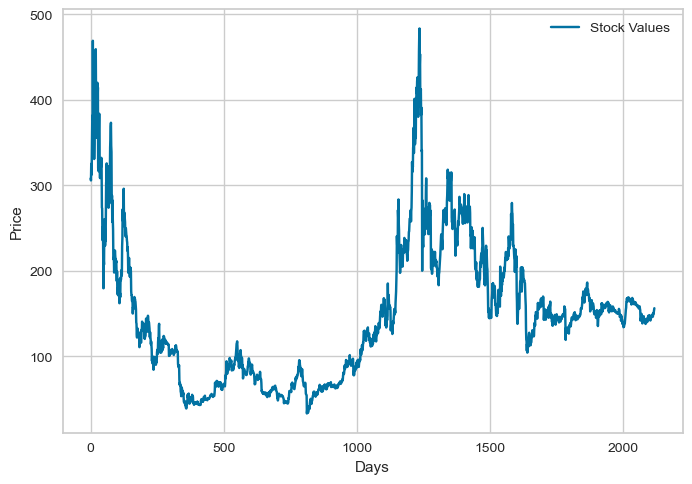

In [461]:
### Calculate EMA Indicator

ema = df['Close'].ewm(com=0.5).mean()
### Add EMA index to dataframe
df['EMA'] = ema

### Comparison plot b/w stock values & EMA
plt.plot(df['Close'], label="Stock Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show() 
### We can see that EMA index predicts out stock value (closing price) pretty good.

In [19]:
### Calculate SMA Indicator

### Get the window of series of observations of specified window size 
window_size = 14
windows = df['Close'].rolling(window_size) 
  
### Create a series of simple moving averages of each window 
sma = windows.mean() 

### Add SMA index to dataframe
df['SMA'] = sma

In [20]:
### Calculate MACD Indicator

### Get the 26-day EMA of the closing price
k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
### Get the 12-day EMA of the closing price
d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()

### Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

### Get the 9-Day EMA of the MACD for the Trigger line
### Slow MACD
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

### Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

### Add MACD new values to the dataframe
df['macd'] = macd
# df_xmr_usd['macd_h'] = macd_h
df['macd_s'] = macd_s

In [21]:
### Calculate Bollinger Band Indicator

# df = df_xmr_usd[['Close']]

# sma = df.rolling(window=20).mean().dropna()
# rstd = df.rolling(window=20).std().dropna()

# upper_band = sma + 2 * rstd
# lower_band = sma - 2 * rstd

# upper_band = upper_band.rename(columns={'Close': 'upper_band'})
# lower_band = lower_band.rename(columns={'Close': 'lower_band'})
# df_xmr_usd = df_xmr_usd.join(upper_band).join(lower_band)
# df_xmr_usd.head(50)

In [22]:
### Drop NaN values because of the nature of RSI, EMA, SMA and MACD calculations >>> This is normal.
df.dropna(inplace=True)
### Reset Index
df.reset_index(drop=True, inplace=True)

### Assign features and target 
y = df['Price_Direction']
X = df.drop(columns=['Price_Direction', 'Date'])

In [23]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,bitcoin_close,ethereum_close,tether_close,...,difficulty,hash,Price_Direction,HighLow,OpenClose,RSI,EMA,SMA,macd,macd_s
0,2017-12-12,281.490997,319.897003,281.187988,308.066986,308.066986,271785984,17415.400391,651.431030,1.077880,...,4.530650e+10,3.775541e+08,0,38.709015,-26.575989,70.806026,295.598508,239.565927,37.679664,32.291742
1,2017-12-13,307.431000,330.346008,284.743988,305.744995,305.744995,248583008,16408.199219,702.767029,1.027160,...,4.513219e+10,3.761016e+08,1,45.602020,1.686005,81.378703,302.362833,249.394141,39.138027,33.660999
2,2017-12-14,303.264008,335.527008,301.395996,325.205994,325.205994,261052992,16564.000000,695.815979,1.008190,...,4.355363e+10,3.629469e+08,0,34.131012,-21.941986,81.992481,317.591607,259.756141,41.387047,35.206209
3,2017-12-15,325.605988,326.075989,296.078003,312.321991,312.321991,163054000,17706.900391,684.447998,1.016100,...,5.051779e+10,4.209816e+08,1,29.997986,13.283997,76.525524,314.078530,268.426425,41.649669,36.494901
4,2017-12-16,312.609985,331.542999,311.710999,327.321014,327.321014,164860992,19497.400391,696.208984,1.007420,...,5.387147e+10,4.489289e+08,1,19.832001,-14.711029,76.819630,322.906853,277.304070,42.577289,37.711379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,2023-10-04,147.168442,150.702347,145.940781,150.469055,150.469055,59400400,27799.394531,1647.838135,1.000437,...,3.423015e+11,2.852512e+09,0,4.761566,-3.300613,55.293492,149.335187,145.995108,0.834988,0.334071
2114,2023-10-05,150.474197,151.328369,148.565491,149.623718,149.623718,55704972,27415.912109,1611.476440,1.000089,...,3.338542e+11,2.782118e+09,1,2.762878,0.850479,60.981030,149.527541,146.311152,0.989592,0.465175
2115,2023-10-06,149.623337,152.669296,148.641647,151.992264,151.992264,49535004,27946.597656,1645.831543,1.000436,...,3.580862e+11,2.984052e+09,1,4.027649,-2.368927,65.502272,151.170690,146.806604,1.288387,0.629817
2116,2023-10-07,151.988235,155.247528,151.100983,155.212143,155.212143,61159796,27968.839844,1634.511230,1.000550,...,3.445453e+11,2.871211e+09,1,4.146545,-3.223907,80.032795,153.864992,147.764794,1.764659,0.856786


In [526]:
temp_df = df.copy()

In [527]:
temp_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close',
       'xrp_close', 'gold_close', 'silver_close', 'copper_close', 'sp_close',
       'difficulty', 'hash', 'Price_Direction', 'HighLow', 'OpenClose', 'RSI',
       'EMA', 'SMA', 'macd', 'macd_s'],
      dtype='object')

In [528]:
temp_df['CloseOpenDiff'] = (temp_df['Close'] - temp_df['Open']) / temp_df['Open']
temp_df['CloseLowDiff'] = (temp_df['Close'] - temp_df['Low']) / temp_df['Open']
temp_df['CloseHighDiff'] = (temp_df['Close'] - temp_df['High']) / temp_df['Open']

In [529]:
for i in range(10):
    temp_df[f'CloseOpenDiff -{i + 1}'] = temp_df['CloseOpenDiff'].shift(i)

for i in range(10):
    temp_df[f'CloseLowDiff -{i + 1}'] = temp_df['CloseLowDiff'].shift(i)
    
for i in range(10):
    temp_df[f'CloseHighDiff -{i + 1}'] = temp_df['CloseHighDiff'].shift(i)

In [530]:
colse_columns = ['Close', 'Volume','bitcoin_close', 'ethereum_close', 'tether_close', 'bnb_close', 'xrp_close',
                     'gold_close', 'silver_close', 'copper_close','sp_close']

# for column in colse_columns:
#     for i in range(14):
#         temp_df[f'{column} -{i + 1}'] = temp_df[column].shift(i)

In [531]:
temp_df['Close Diff -1'] = (temp_df['Close'] - temp_df['Close'].shift(1)) / temp_df['Close'].shift(1)
temp_df['Close Diff -2'] = (temp_df['Close'].shift(1) - temp_df['Close'].shift(2)) / temp_df['Close'].shift(2)
temp_df['Close Diff -3'] = (temp_df['Close'].shift(2) - temp_df['Close'].shift(3)) / temp_df['Close'].shift(3)
temp_df['Close Diff -4'] = (temp_df['Close'].shift(3) - temp_df['Close'].shift(4)) / temp_df['Close'].shift(4)
# temp_df['Close Diff -5'] = (temp_df['Close'].shift(4) - temp_df['Close'].shift(5)) / temp_df['Close'].shift(5)
# temp_df['Close Diff -6'] = (temp_df['Close'].shift(5) - temp_df['Close'].shift(6)) / temp_df['Close'].shift(6)
# temp_df['Close Diff -7'] = (temp_df['Close'].shift(6) - temp_df['Close'].shift(7)) / temp_df['Close'].shift(7)
# temp_df['Close Diff -8'] = (temp_df['Close'].shift(7) - temp_df['Close'].shift(8)) / temp_df['Close'].shift(8)
# temp_df['Close Diff -9'] = (temp_df['Close'].shift(8) - temp_df['Close'].shift(9)) / temp_df['Close'].shift(9)
# temp_df['Close Diff -10'] = (temp_df['Close'].shift(9) - temp_df['Close'].shift(10)) / temp_df['Close'].shift(10)

In [532]:
temp_df['BTC Diff -1'] = (temp_df['bitcoin_close'] - temp_df['bitcoin_close'].shift(1)) / temp_df['bitcoin_close'].shift(1)
temp_df['BTC Diff -2'] = (temp_df['bitcoin_close'].shift(1) - temp_df['bitcoin_close'].shift(2)) / temp_df['bitcoin_close'].shift(2)
temp_df['BTC Diff -3'] = (temp_df['bitcoin_close'].shift(2) - temp_df['bitcoin_close'].shift(3)) / temp_df['bitcoin_close'].shift(3)
# temp_df['BTC Diff -4'] = (temp_df['bitcoin_close'].shift(3) - temp_df['bitcoin_close'].shift(4)) / temp_df['bitcoin_close'].shift(4)
# temp_df['BTC Diff -5'] = (temp_df['bitcoin_close'].shift(4) - temp_df['bitcoin_close'].shift(5)) / temp_df['bitcoin_close'].shift(5)
# temp_df['BTC Diff -6'] = (temp_df['bitcoin_close'].shift(5) - temp_df['bitcoin_close'].shift(6)) / temp_df['bitcoin_close'].shift(6)
# temp_df['BTC Diff -7'] = (temp_df['bitcoin_close'].shift(6) - temp_df['bitcoin_close'].shift(7)) / temp_df['bitcoin_close'].shift(7)
# temp_df['BTC Diff -8'] = (temp_df['bitcoin_close'].shift(7) - temp_df['bitcoin_close'].shift(8)) / temp_df['bitcoin_close'].shift(8)
# temp_df['BTC Diff -9'] = (temp_df['bitcoin_close'].shift(8) - temp_df['bitcoin_close'].shift(9)) / temp_df['bitcoin_close'].shift(9)
# temp_df['BTC Diff -10'] = (temp_df['bitcoin_close'].shift(9) - temp_df['bitcoin_close'].shift(10)) / temp_df['bitcoin_close'].shift(10)


In [533]:
temp_df['ETH Diff -1'] = (temp_df['ethereum_close'] - temp_df['ethereum_close'].shift(1)) / temp_df['ethereum_close'].shift(1)
temp_df['ETH Diff -2'] = (temp_df['ethereum_close'].shift(1) - temp_df['ethereum_close'].shift(2)) / temp_df['ethereum_close'].shift(2)
temp_df['ETH Diff -3'] = (temp_df['ethereum_close'].shift(2) - temp_df['ethereum_close'].shift(3)) / temp_df['ethereum_close'].shift(3)
# temp_df['ETH Diff -4'] = (temp_df['ethereum_close'].shift(3) - temp_df['ethereum_close'].shift(4)) / temp_df['ethereum_close'].shift(4)
# temp_df['ETH Diff -5'] = (temp_df['ethereum_close'].shift(4) - temp_df['ethereum_close'].shift(5)) / temp_df['ethereum_close'].shift(5)
# temp_df['ETH Diff -6'] = (temp_df['ethereum_close'].shift(5) - temp_df['ethereum_close'].shift(6)) / temp_df['ethereum_close'].shift(6)
# temp_df['ETH Diff -7'] = (temp_df['ethereum_close'].shift(6) - temp_df['ethereum_close'].shift(7)) / temp_df['ethereum_close'].shift(7)
# temp_df['ETH Diff -8'] = (temp_df['ethereum_close'].shift(7) - temp_df['ethereum_close'].shift(8)) / temp_df['ethereum_close'].shift(8)
# temp_df['ETH Diff -9'] = (temp_df['ethereum_close'].shift(8) - temp_df['ethereum_close'].shift(9)) / temp_df['ethereum_close'].shift(9)
# temp_df['ETH Diff -10'] = (temp_df['ethereum_close'].shift(9) - temp_df['ethereum_close'].shift(10)) / temp_df['ethereum_close'].shift(10)


In [534]:
temp_df['SP Diff -1'] = (temp_df['sp_close'] - temp_df['sp_close'].shift(1)) / temp_df['sp_close'].shift(1)
temp_df['SP Diff -2'] = (temp_df['sp_close'].shift(1) - temp_df['sp_close'].shift(2)) / temp_df['sp_close'].shift(2)
temp_df['SP Diff -3'] = (temp_df['sp_close'].shift(2) - temp_df['sp_close'].shift(3)) / temp_df['sp_close'].shift(3)
# temp_df['SP Diff -4'] = (temp_df['sp_close'].shift(3) - temp_df['sp_close'].shift(4)) / temp_df['sp_close'].shift(4)
# temp_df['SP Diff -5'] = (temp_df['sp_close'].shift(4) - temp_df['sp_close'].shift(5)) / temp_df['sp_close'].shift(5)
# temp_df['SP Diff -6'] = (temp_df['sp_close'].shift(5) - temp_df['sp_close'].shift(6)) / temp_df['sp_close'].shift(6)
# temp_df['SP Diff -7'] = (temp_df['sp_close'].shift(6) - temp_df['sp_close'].shift(7)) / temp_df['sp_close'].shift(7)
# temp_df['SP Diff -8'] = (temp_df['sp_close'].shift(7) - temp_df['sp_close'].shift(8)) / temp_df['sp_close'].shift(8)
# temp_df['SP Diff -9'] = (temp_df['sp_close'].shift(8) - temp_df['sp_close'].shift(9)) / temp_df['sp_close'].shift(9)
# temp_df['SP Diff -10'] = (temp_df['sp_close'].shift(9) - temp_df['sp_close'].shift(10)) / temp_df['sp_close'].shift(10)


In [535]:
temp_df.dropna(inplace=True)
# reset idnex
temp_df.reset_index(drop=True, inplace=True)

In [536]:
# temp_df['Index'] = temp_df.index + 1

In [537]:
temp_df['Target'] = temp_df['Close'].shift(-1)
temp_df['Target'] = temp_df['Price_Direction']

In [538]:
train = temp_df.iloc[:-230]
test = temp_df.iloc[-30:]
validation = temp_df.iloc[-230:-30]

In [539]:
# features = train.drop(columns=['Price_Direction', 'Date'])
features = train.drop(['Date','Price_Direction', 'Adj Close', 'Target'], axis=1)
target = train['Target']
X_train = features.values
y_train = target.values

In [540]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)

In [541]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRFRegressor

In [542]:
from sklearn.ensemble import ExtraTreesRegressor

In [543]:
y_preds = []
for index, row in validation.iterrows():
    print(len(y_preds))
    # model = SVR(kernel='rbf')
    # model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    # model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=6)
    model = SVC(kernel='rbf')
    # model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=6)
    # model = LogisticRegression(random_state=42, max_iter=1000)
    # model = XGBClassifier(random_state=42, max_depth = 5, n_estimators = 80)
    # model = XGBRFRegressor(random_forest=42, max_depth=5, n_estimators=80)
    model.fit(X_train, y_train)
    y_test = np.array([row['Target']])
    x_test = row[features.columns].values.reshape(1, -1)
    x_test = ss.transform(x_test)
    y_pred = model.predict(x_test)
    y_preds.append(y_pred[0])
    X_train = np.concatenate((X_train, x_test), axis=0)
    y_train = np.concatenate((y_train, y_test), axis=0)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [544]:
features_impotance = pd.DataFrame()

In [547]:
# features_impotance['importance'] = model.feature_importances_
# features_impotance['feature'] = train.columns.drop(['Date','Price_Direction', 'Adj Close', 'Target'])
# features_impotance.sort_values(by='importance', ascending=False).iloc[:20]

In [548]:
(y_preds == validation['Target'].values).mean()
f1_score(validation['Target'].values, y_preds)

0.6801346801346801

In [549]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(validation['Target'].values, y_preds))
print(precision_score(validation['Target'].values, y_preds))

0.9528301886792453
0.5287958115183246
